Learning Deep Features for Discriminative Localization<br>
https://arxiv.org/abs/1512.04150

<img src='https://i.imgur.com/yitzLB1.png' width='100%'>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms # data preprocessing
from torch.utils.data import DataLoader # mini-batch
import torch.nn.functional as F
import torch.nn as nn   # loss
import torch.optim as optim # optimizer

import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/My Drive/Pytorch/DL bro/cam/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
resize = 128
transform = transforms.Compose(
    [transforms.Resize(resize), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.STL10(root=path+'data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

# 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truch

Files already downloaded and verified


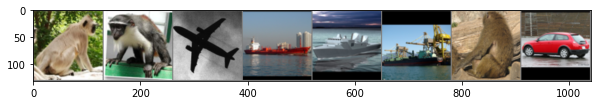

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imgshow(img):

    img = img/2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images[:8]))

In [ ]:
model = torchvision.models.alexnet(pretrained=False)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from collections import OrderedDict

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):

        x=x.mean([2,3])
        x=F.relu(self.fc1(x))
        x=F.softmax(self.fc2(x), dim=1)

        return x

model.features[8] = nn.Conv2d(384, 512, 3)
model = nn.Sequential(OrderedDict([('features', model.features[:10]), ('classifier', Classifier())]))
model = model.to(device)

In [ ]:
model

Sequential(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
old_loss = 10

for epoch in range(100):#100

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    cost = running_loss / len(trainloader)
    print('[%d] loss: %.3f' %(epoch+1, cost))

print('Finished Training')

[1] loss: 2.249
[2] loss: 2.187
[3] loss: 2.154
[4] loss: 2.136
[5] loss: 2.139
[6] loss: 2.121
[7] loss: 2.097
[8] loss: 2.079
[9] loss: 2.068
[10] loss: 2.062
[11] loss: 2.047
[12] loss: 2.029
[13] loss: 2.023
[14] loss: 2.025
[15] loss: 2.005
[16] loss: 2.007
[17] loss: 1.997
[18] loss: 1.993
[19] loss: 1.987
[20] loss: 1.977
[21] loss: 1.961
[22] loss: 1.957
[23] loss: 1.957
[24] loss: 1.943
[25] loss: 1.930
[26] loss: 1.930
[27] loss: 1.917
[28] loss: 1.904
[29] loss: 1.904
[30] loss: 1.897
[31] loss: 1.887
[32] loss: 1.889
[33] loss: 1.876
[34] loss: 1.877
[35] loss: 1.860
[36] loss: 1.855
[37] loss: 1.841
[38] loss: 1.848
[39] loss: 1.836
[40] loss: 1.823
[41] loss: 1.825
[42] loss: 1.807
[43] loss: 1.813
[44] loss: 1.801
[45] loss: 1.805
[46] loss: 1.800
[47] loss: 1.780
[48] loss: 1.778
[49] loss: 1.767
[50] loss: 1.764
[51] loss: 1.769
[52] loss: 1.760
[53] loss: 1.748
[54] loss: 1.741
[55] loss: 1.738
[56] loss: 1.736
[57] loss: 1.730
[58] loss: 1.723
[59] loss: 1.717
[60] l

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
PATH = path+'cam_model.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
print(model)

Sequential(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
def cam(model, img_sample, img_size):
    model.eval()
    model.features[9].register_forward_hook(get_activation('final'))
    data, _ = trainset[img_sample]
    data.unsqueeze_(0)
    output = model(data.to(device))
    act = activation['final'].squeeze()

    for idx in range(act.size(0)):
        if idx==0:
            tmp = act[idx]*act[idx].mean()
        else:
            tmp += act[idx]*act[idx].mean()

    normalized_cam = tmp.cpu().numpy()
    normalized_cam = (normalized_cam - np.min(normalized_cam))/(np.max(normalized_cam)-np.min(normalized_cam))

    cam_img = cv2.resize(np.uint8(normalized_cam*255), dsize=(img_size, img_size))
    original_img = np.uint8((data[0][0]/2+0.5)*255)

    return cam_img, original_img


def plot_cam(model, start, img_size):

    end = start + 20
    fig, axs = plt.subplots(2, (end-start+1)//2, figsize=(20,5))
    fig.subplots_adjust(hspace= .01, wspace= .01)
    axs = axs.ravel()

    for i in range(start, end):
        cam_img, original_img = cam(model, i, img_size)

        axs[i-start].imshow(original_img, cmap='gray')
        axs[i-start].imshow(cam_img, cmap='jet', alpha=.5)
        axs[i-start].axis('off')
    
    plt.show()

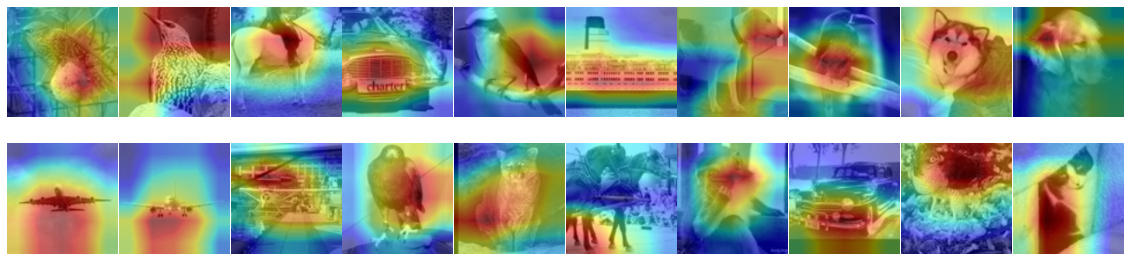

In [ ]:
plot_cam(model, 20, resize)

In [ ]:
correct= 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Train Accuracy: %d %%' %(
    100 * correct/ total
))

Train Accuracy: 86 %
